### Jose Mijangos<br>Kirk Worley<br>Victoria Zamora<br>CST 463<br>Oct 17, 2018
# Predicting If Individuals Will Default on Payments Next Month
## Introduction
After a client defaults on credit card debt, the bank usually closes the clients card and sells their account to a collections agency for less than what is owed. The client will now owe their debt to the agency and can be sued for not complying. Hence, defaulting on credit card debt is very serious because both the client and the bank suffer financially when this occurs.  

Our motivation is to develop a classifier that will predict whether a consumer will default on credit card debt by performing analyses to determine which features are the best predictors of defaulting. While the true probability of defaulting is unknown, from a risk management perspective, being able to achieve a high accuracy on predictions of defaulting allows banks to drastically cut losses and act accordingly with clients. The power of prediction helps mitigate damages due to clients consistently not fulfilling their obligations to their debts.

## Imported Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
sns.set(style='darkgrid')
np.random.seed(33928)

C:\Users\Josemij39\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load Data

In [2]:
dat = pd.read_csv('C:/Users/Josemij39/Desktop/CCDD_Classifier/default_cc_train.csv')

## Exploration

### Basic/Standard Info of Dataset

The title of the dataset is 'Default of Credit Card Clients'. We obtained this data from UCI Machine Learning Repository. The data was donated January 26, 2016. We accessed this data on October 2018. This dataset has a total of 2,500 rows and 25 columns.



### Missing Values
First, we checked for NA values; there were none.

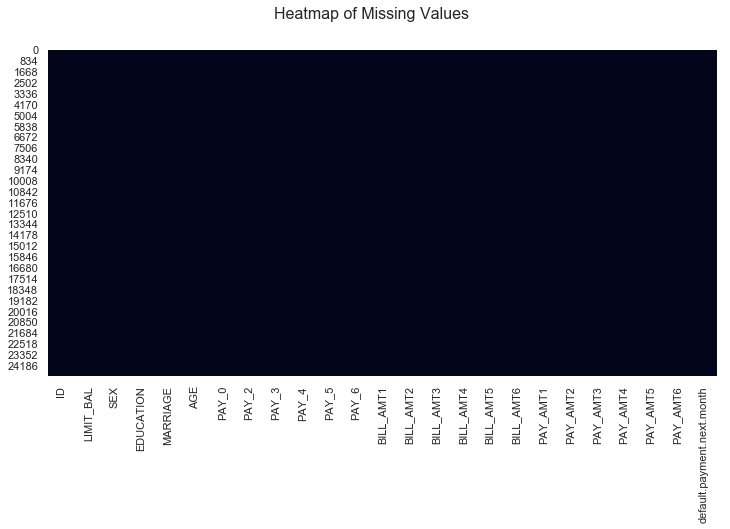

In [3]:
plt.figure(figsize=(12,6))
sns.heatmap(dat.isnull(), cbar=False)
plt.suptitle('Heatmap of Missing Values', fontsize=16);

### Distribution of Clients who Default

Our goal is to predict whether a client defaults or not, so how many clients from this dataset actually defaulted?
According to the barplot below, approximately 78% of clients did not default and approximately 22% did default.

C:\Users\Josemij39\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


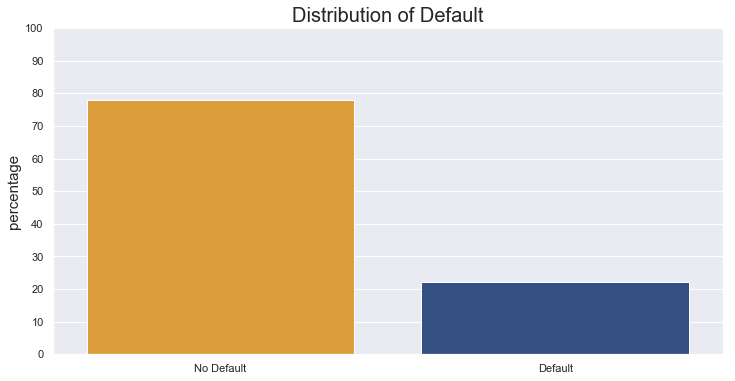

In [4]:
plt.figure(figsize=(12,6))
pal = ["#f7a520","#284d8c"]
ax = sns.barplot(x="default.payment.next.month", y="default.payment.next.month", data=dat, palette = pal, estimator=lambda x: len(x) / len(dat) * 100)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(["No Default","Default"])
plt.title("Distribution of Default", fontsize=20)
plt.ylabel("percentage", fontsize=15)
plt.xlabel("");

### Credit Limit by Age for each Class

The older a person is, the more time he or she has to become financially stable. Hence, we were curious as to whether or not older people would have a higher credit limit. From the scatter plot below, it appears that credit limit slightly increases as age increases but for the most part the plot looks rather uniform across. However, those who default have a much higher credit limit than those who do not.



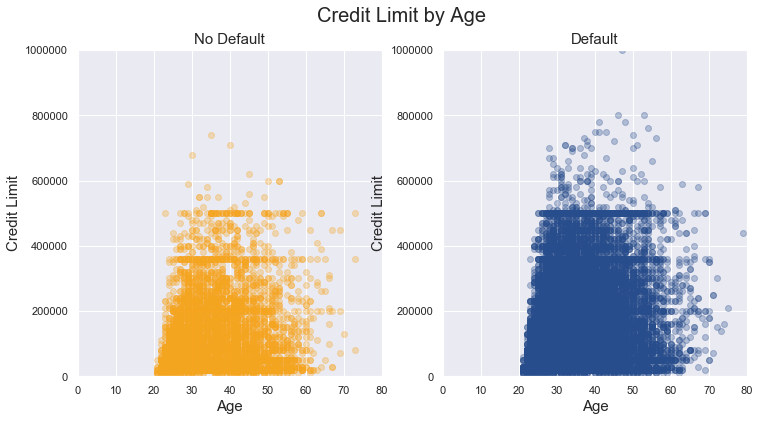

In [5]:
no_default = dat.loc[dat["default.payment.next.month"] == 0]
default = dat.loc[dat["default.payment.next.month"] == 1]

fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_title("No Default", fontsize=15)
ax[0].set_ylim((0, 1000000))
ax[0].set_xlim((0, 80))
ax[0].set_ylabel("Credit Limit", fontsize=15)
ax[0].set_xlabel("Age", fontsize=15)
ax[0].scatter(default['AGE'], default['LIMIT_BAL'], alpha=.3, color ="#f7a520" )

ax[1].set_title("Default", fontsize=15)
ax[1].set_ylim((0, 1000000))
ax[1].set_xlim((0, 80))
ax[1].set_ylabel("Credit Limit", fontsize=15)
ax[1].set_xlabel("Age", fontsize=15)
ax[1].scatter(no_default['AGE'], no_default['LIMIT_BAL'], alpha=.3, color="#284d8c")
fig.suptitle('Credit Limit by Age', fontsize=20);

### Distribution of Age for each Class

Next, we examined the age distribution of clients by default and no default. Roughly 99% of the clients are between the ages of 20 and 80. Although there is a slight hump in the distribution for those who defaulted, both distributions seem to be unimodal. About 5% of those who did not default are 27-28 while 4.4% of those who default are 25-26. Also, between the ages of 26 and 41, more clients do not default. From ages 18 to 24, slightly more clients default than not. While ages 41-62 also have a slightly higher percentage of those who default compared to those who do not.

C:\Users\Josemij39\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


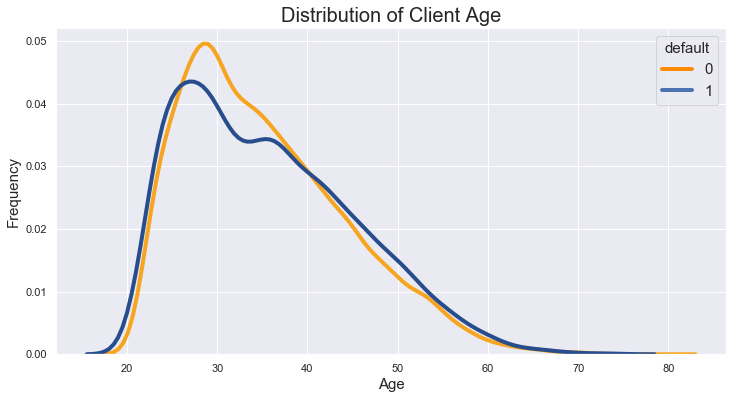

In [34]:
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 15})
sns.set_context(rc={"lines.linewidth": 4})
sns.distplot(no_default["AGE"], hist=False, color = "#f7a520")
sns.distplot(default["AGE"], hist=False, color = "#284d8c")
plt.title("Distribution of Client Age", fontsize=20)
plt.xlabel("Age", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
legend_elements = [Line2D([0], [0], marker='_', color='darkorange', label='0',
                          markerfacecolor='darkorange', markersize=18),
                   Line2D([0], [0], marker='_', color='b', label='1',
                          markerfacecolor='blue', markersize=18)]
plt.legend(handles=legend_elements, title="default", fontsize=15)
sns.set_context(rc={"lines.linewidth": 2});

### Distribution of Credit Limit for each Class

From the density plot below, roughly estimating, we can see that once a client's credit limit surpasses 120,000, there is a higher probability that he or she defaults. On the other hand, there is a much higher percentage of not defaulting for clients with credit limit under 120,000. 


C:\Users\Josemij39\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


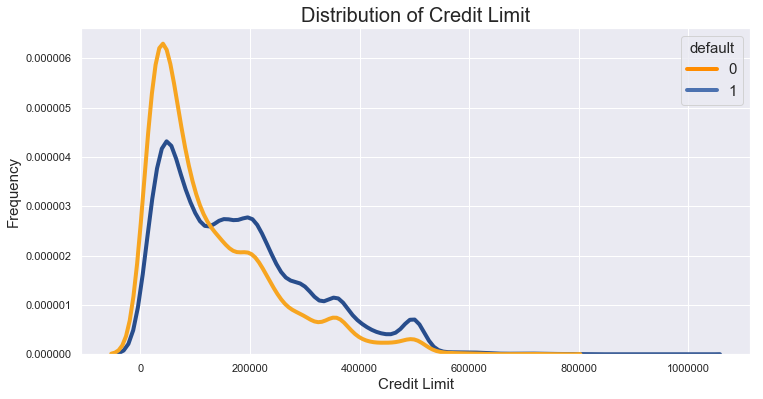

In [33]:
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 15})
sns.set_context(rc={"lines.linewidth": 4})
sns.distplot(no_default["LIMIT_BAL"], hist=False, color="#284d8c")
sns.distplot(default["LIMIT_BAL"], hist=False, color="#f7a520" )
plt.title("Distribution of Credit Limit", fontsize=20)
plt.xlabel("Credit Limit", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
legend_elements = [Line2D([0], [0], marker='_', color='darkorange', label='0',
                          markerfacecolor='darkorange', markersize=18),
                   Line2D([0], [0], marker='_', color='b', label='1',
                          markerfacecolor='blue', markersize=18)]
plt.legend(handles=legend_elements, title="default", fontsize=15)
sns.set_context(rc={"lines.linewidth": 2});

### Distribution of Clients who Default by Marital Status

Is marital status possibly a good predictor? Below, we show the percentage of clients who did default and clients who did not by their marital status. Of those that are married, over half of them did indeed default. Of those that are single, a higher percentage did not default. Overall however, single clients had a slightly  higher percentage of defaulting than married clients. Although the difference was not large enough to be significant, one theory we had to explain the difference was that married clients may have their spouse/partner help pay off credit card debt.

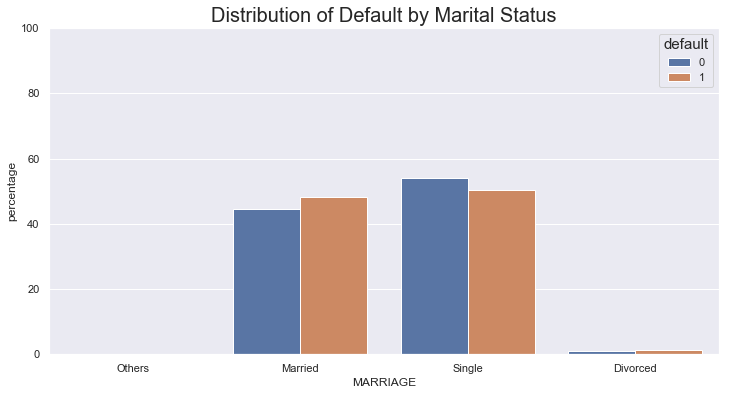

In [32]:
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 15})
counts = (dat.groupby(['default.payment.next.month'])['MARRIAGE']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())

ax = sns.barplot(x="MARRIAGE", y="percentage", hue="default.payment.next.month", data=counts)
ax.set_xticklabels(["Others","Married","Single","Divorced"])
plt.title("Distribution of Default by Marital Status", fontsize=20)
plt.ylim((0, 100))
plt.legend(title="default");

### Distribution of Clients who Default by Education

Failing to find significance of default by marital status, we moved on to default by education level. For both those who graduated from a university and those who graduated from high school, we see that a higher percentage defaulted than not. While for those who graduated from graduate school had a higher percentage of not defaulting- which makes sense. If a client finished graduate school, we assume he or she has a much higher pay than university and high school graduates. This also means her or she has more money to make payments toward their credit card bills.

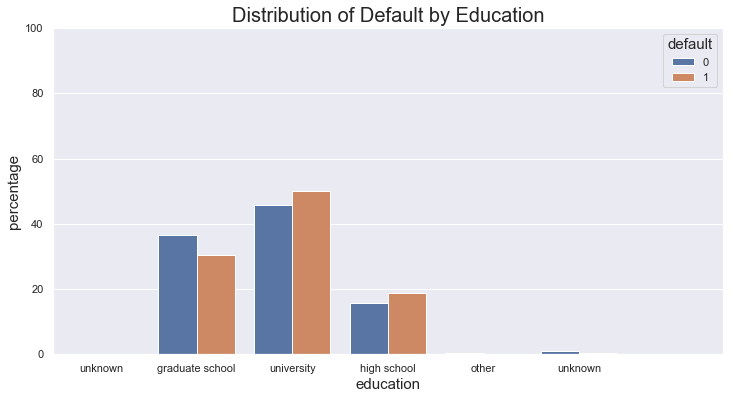

In [31]:
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 15})
counts = (dat.groupby(['default.payment.next.month'])['EDUCATION']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())

ax = sns.barplot(x="EDUCATION", y="percentage", hue="default.payment.next.month", data=counts)
ax.set_xticklabels(["unknown","graduate school","university","high school", "other", "unknown"])
plt.title("Distribution of Default by Education", fontsize=20)
plt.ylabel("percentage", fontsize=15)
plt.xlabel("education", fontsize=15)
plt.ylim((0, 100))
plt.legend(title="default");

### Distribution of Default by Sex

What about gender? Are women more fiscally responsible than men or vice versa? From the barplot below, we see a higher percentage of females defaulted than males, but we believe this is because there are 1.5 times more females than males in the dataset. More males defaulted than males who did not default. While more women did not default compared those women who did.

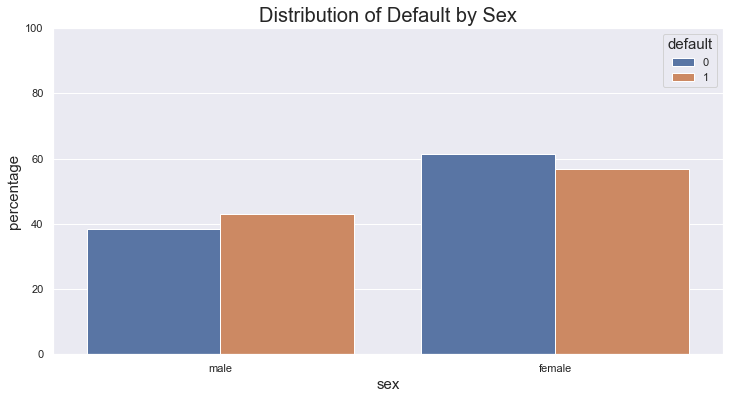

In [30]:
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 15})
counts = (dat.groupby(['default.payment.next.month'])['SEX']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())

ax = sns.barplot(x="SEX", y="percentage", hue="default.payment.next.month", data=counts)
plt.title("Distribution of Default by Sex", fontsize=20)
plt.ylim((0, 100))
plt.ylabel("percentage", fontsize=15)
plt.xlabel("sex", fontsize=15)
ax.set_xticklabels(["male","female"])
plt.legend(title="default");

## Time Series Analysis
The data set contains recordings of clients bill and pay amount that were taken at regular one month intervals for a six month period of time. We can use these features to analyse temporal trends associated with clients monthly bill and pay amount.
### Convert Wide Data to Long Data
Currently within the data, every period of time has its own column. For convenience we will need to transform the structure of the data so that there is only one column for time and one column for the target value.

In [11]:
no_default_wide = dat.loc[dat["default.payment.next.month"] == 0]
default_wide = dat.loc[dat["default.payment.next.month"] == 1]

bill_no_default = no_default_wide[["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]]
bill_no_default.columns = ["April", "May", "June", "July", "Aug", "Sept"]
bill_no_default = pd.melt(bill_no_default, var_name="month", value_name="bill")

bill_default = default_wide[["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]]
bill_default.columns = ["April", "May", "June", "July", "Aug", "Sept"]
bill_default = pd.melt(bill_default, var_name="month", value_name="bill")

### Create Time Series to compare Positive and Negative Classes
For our purposes, we are interested in comparing the time series of clients who do not default with clients who do default on their credit card payment. We can compare a single feature at a time or compare how multiple features interact with each other for each class. The code below derives features by dividing pay by bill and multiplying bill by pay. We specifically choose to divide bill by pay to represent what percent of the bill the client pays.

In [12]:
pay_no_default = no_default_wide[["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]]
pay_no_default.columns = ["April", "May", "June", "July", "Aug", "Sept"]
pay_no_default = pd.melt(pay_no_default, var_name="month", value_name="pay")

pay_default = default_wide[["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]]
pay_default.columns = ["April", "May", "June", "July", "Aug", "Sept"]
pay_default = pd.melt(pay_default, var_name="month", value_name="pay")

div_no_default = pd.concat([bill_no_default["month"], pay_no_default["pay"] / (.001 + bill_no_default["bill"])], axis=1)
div_no_default.columns = ["month", "pay/bill"]

div_default = pd.concat([bill_default["month"], pay_default["pay"] / (.001 + bill_default["bill"])], axis=1)
div_default.columns = ["month", "pay/bill"]

rec_no_default = pd.concat([bill_no_default["month"], bill_no_default["bill"] / (.001 + pay_no_default["pay"])], axis=1)
rec_no_default.columns = ["month", "bill/pay"]

rec_default = pd.concat([bill_default["month"], bill_default["bill"] / (.001 + pay_default["pay"])], axis=1)
rec_default.columns = ["month", "bill/pay"]

prod_no_default = pd.concat([bill_no_default["month"], bill_no_default["bill"] * pay_no_default["pay"]], axis=1)
prod_no_default.columns = ["month", "bill*pay"]

prod_default = pd.concat([bill_default["month"], bill_default["bill"] * pay_default["pay"]], axis=1)
prod_default.columns = ["month", "bill*pay"]

### Bill Time Series by Class
Both classes have bill time series that are generally decreasing. However, the rate of decrease is greater for clients that do not default on their credit card payment. Unlike the negative class, the median bill amount for the positive class remains constant over time.

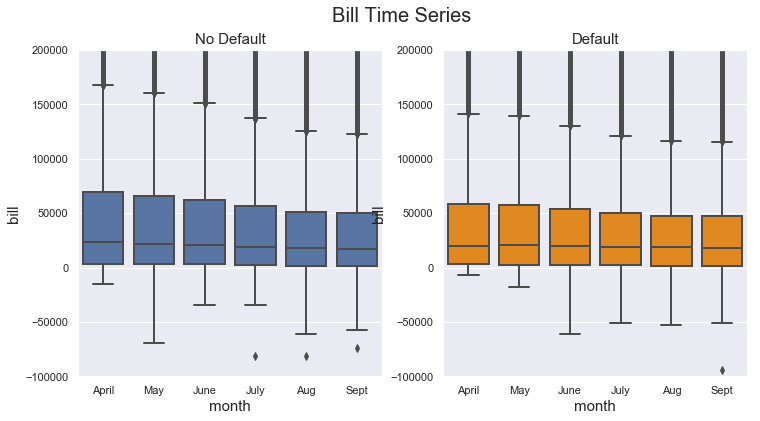

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_ylim((-100000, 200000))
ax[0].set_ylabel("", fontsize=15)
ax[0].set_xlabel("", fontsize=15)
ax[0].set_title("No Default", fontsize=15)
ax[1].set_ylim((-100000, 200000))
ax[1].set_ylabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[1].set_title("Default", fontsize=15)
sns.catplot("month", y="bill", data=bill_no_default, kind="box", color="b", ax=ax[0])
plt.close()
sns.catplot("month", y="bill", data=bill_default, kind="box", color="darkorange", ax=ax[1])
plt.close()
fig.suptitle('Bill Time Series', fontsize=20);

### Pay Time Series by Class
The pay time series for each class is again decreasing. On average, clients that do not default on credit card debt pay more each month than clients that do default on credit card debt. Also note that clients that do not default are unlikely to make payments less than about five-hundred dollars.

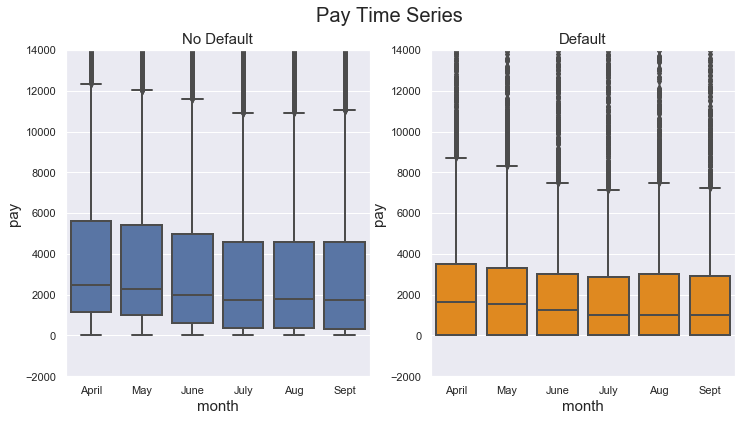

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_ylim((-2000, 14000))
ax[0].set_ylabel("", fontsize=15)
ax[0].set_xlabel("", fontsize=15)
ax[0].set_title("No Default", fontsize=15)
ax[1].set_ylim((-2000, 14000))
ax[1].set_ylabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[1].set_title("Default", fontsize=15)
sns.catplot("month", y="pay", data=pay_no_default, kind="box", color="b", ax=ax[0])
plt.close()
sns.catplot("month", y="pay", data=pay_default, kind="box", color="darkorange", ax=ax[1])
plt.close()
fig.suptitle('Pay Time Series', fontsize=20);

### Pay divided by Bill Time Series
The time series become very distinct when comparing the percent of bill paid for the positive and negative classes. It is rare for someone to pay more than fifthteen percent of their bill given that person belongs to the positive class. It is also rare for someone in the positive class to have a negative percent of bill paid. This suggests that for the positive class, if the bill is negative, then the client usually does not make a large payment.

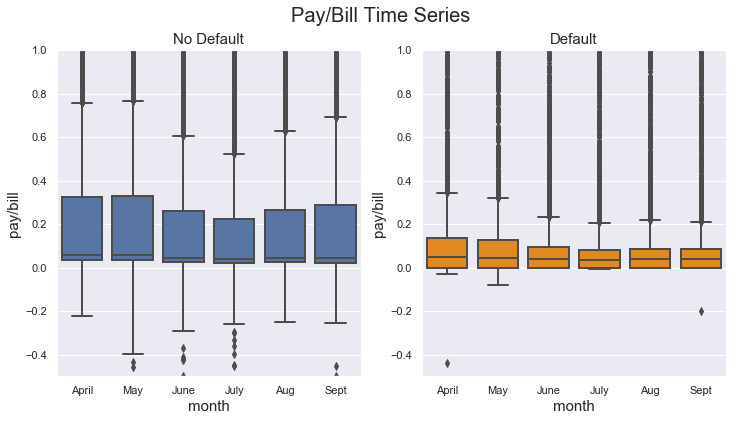

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_ylim((-.5, 1))
ax[0].set_ylabel("", fontsize=15)
ax[0].set_xlabel("", fontsize=15)
ax[0].set_title("No Default", fontsize=15)
ax[1].set_ylim((-.5, 1))
ax[1].set_ylabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[1].set_title("Default", fontsize=15)
sns.catplot("month", y="pay/bill", data=div_no_default, kind="box", color="b", ax=ax[0])
plt.close()
sns.catplot("month", y="pay/bill", data=div_default, kind="box", color="darkorange", ax=ax[1])
plt.close()
fig.suptitle('Pay/Bill Time Series', fontsize=20);

### Bill times Pay Time Series
The product of bill and pay amount is less interpretable but the difference in the produced time series is prevalent. The time series for the negative class has greater variance than the negative class and decreases at a much faster rate.

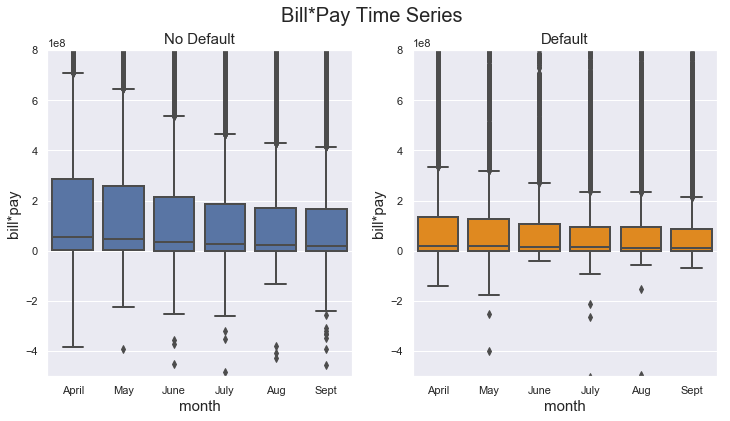

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_ylabel("", fontsize=15)
ax[0].set_xlabel("", fontsize=15)
ax[0].set_ylim((-500000000, 800000000))
ax[0].set_title("No Default", fontsize=15)
ax[1].set_ylabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[1].set_ylim((-500000000, 800000000))
ax[1].set_title("Default", fontsize=15)
sns.catplot("month", y="bill*pay", data=prod_no_default, kind="box", color="b", ax=ax[0])
plt.close()
sns.catplot("month", y="bill*pay", data=prod_default, kind="box", color="darkorange", ax=ax[1])
plt.close()
fig.suptitle('Bill*Pay Time Series', fontsize=20);

##  Data Preprocessing
We have to prepare the data by scaling numeric features and encoding categorical features before we begin applying machine learning methods.
### Custom Transformer
DataFrameSelector will be used to project the data and MultColumnLabelEncoder will be used for the encoding of categorical features.


In [17]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        output = X.copy()        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

### Preprocessing Pipeline
Our pipeline needs to know which features are numeric and which are categorical before it can be used.

In [18]:
num_features = dat.columns[[1,5,12,13,14,15,16,17,18,19,20,21,22,23]]
cat_features = dat.columns[[2,3,4,6,7,8,9,10,11]]
class_labels = dat.columns[-1]

num_pipeline = Pipeline([
  ("selector", DataFrameSelector(num_features)),
  ("remove_nas", Imputer(strategy="median")),
  ("z-scaling", StandardScaler())
])

cat_pipeline = Pipeline([
  ('selector', DataFrameSelector(cat_features)),
  ('labeler', MultiColumnLabelEncoder()),
  ('encoder', OneHotEncoder(sparse = False)),
])

### Split Data for Machine Learning
Now we store the preprocessed data in X and the class labels in y. Then we split the data for training and testing our machine learning methods.

In [19]:
X = pd.DataFrame(np.concatenate((num_pipeline.fit_transform(dat), cat_pipeline.fit_transform(dat)), 1))
y = dat["default.payment.next.month"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

## Principal Component Analysis
Currently our preprocessed data has ninety features. To better represent this data graphically we perform dimensionality reduction via principal component analysis. Our goal is to determine how separable the classes are within the data.

### Cumulative Explained Variance Ratio
The plot represents the amount of the total information in the data represented by a number of principal components. For our data set you would need twenty principal components to retain at least have ninety-five percent of the total information.

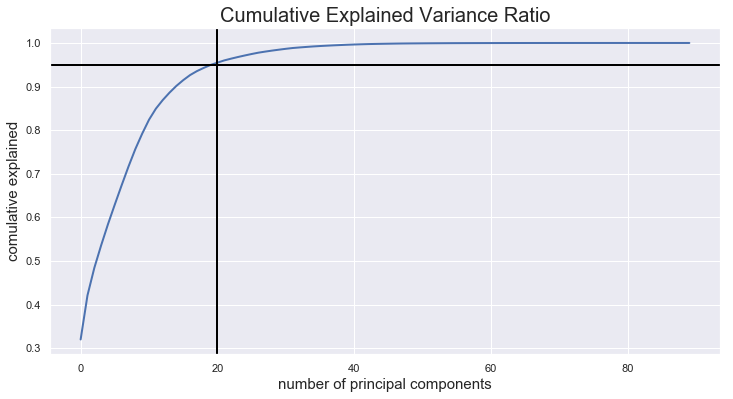

In [20]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum > 0.95)

plt.figure(figsize=(12,6))
sns.lineplot(data=cumsum)
plt.axvline(x=d, color = "black")
plt.axhline(y=.95, color = "black")
plt.xlabel('number of principal components', fontsize=15)
plt.ylabel('comulative explained', fontsize=15)
plt.title('Cumulative Explained Variance Ratio', fontsize=20);

### Visualizing Data with Two Principal Components
We can represent the data in 2D by using two principal components. The classes appear quite intertwined and not separable at all. However, is possible that the plot is misleading because only clients that default the very next month are part of the positive class. The plot would look a lot different if clients that eventually default on payments in the near future were also part of the positive class

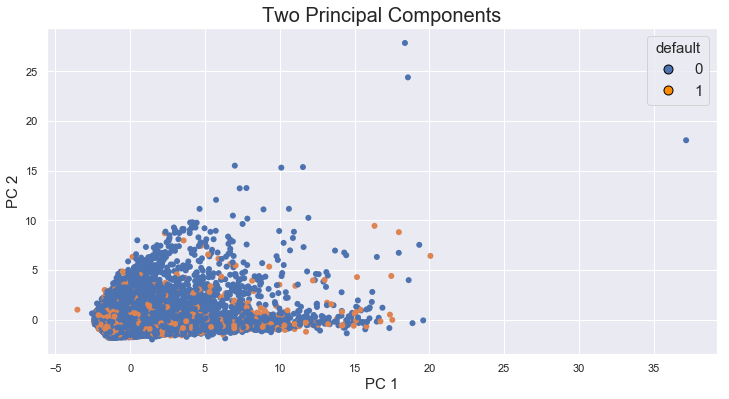

In [29]:
pca = PCA(n_components=2)
X_PCA = pd.concat([pd.DataFrame(pca.fit_transform(X)), dat["default.payment.next.month"]], axis=1)

plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 15})
sns.scatterplot(x=0, y=1, hue="default.payment.next.month", data=X_PCA, linewidth=0)
plt.title('Two Principal Components', fontsize=20)
plt.xlabel('PC 1', fontsize=15)
plt.ylabel('PC 2', fontsize=15)
legend_elements = [Line2D([0], [0], marker='.', color='none', label='0',
                          markerfacecolor='b', markersize=18),
                   Line2D([0], [0], marker='.', color='none', label='1',
                          markerfacecolor='darkorange', markersize=18)]
plt.legend(handles=legend_elements, title="default", fontsize=15);

### Visualizing Data with Three Principal Components
The addition of another dimension increases the presence of distinct clusters. Perhaps k nearest neighbor would perform well on this data. Again the plot is misleading because we do not know which clients default after next month.

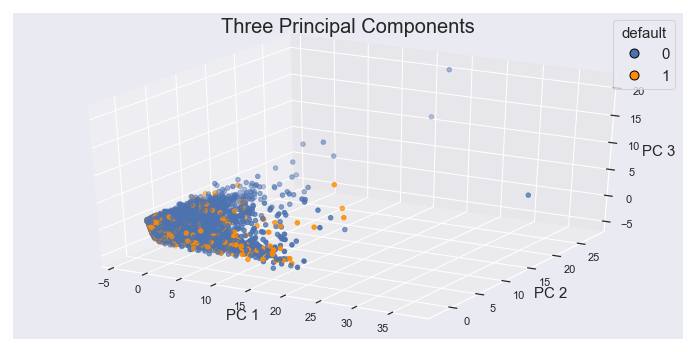

In [22]:
pca = PCA(n_components=3)
X_PCA = pd.concat([pd.DataFrame(pca.fit_transform(X)), dat["default.payment.next.month"]], axis=1)

plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
color=np.array(["b", "darkorange"])
ax.scatter(X_PCA[0], X_PCA[1], X_PCA[2], c=color[X_PCA["default.payment.next.month"]], marker='o')
plt.title('Three Principal Components', fontsize=20)
ax.set_xlabel('PC 1', fontsize=15)
ax.set_ylabel('PC 2', fontsize=15)
ax.set_zlabel('PC 3', fontsize=15)
ax.legend(handles=legend_elements, title="default", fontsize=15);

## Utility Functions
Below, we will define a function that compares two scores. This will be used later to compare model accuracy to a baseline accuracy that we will establish in the future. We will also define a function that prints some confusion matrix metrics. Additionally, we will define a function to plot learning curves given an estimator. The plot_learning_curve function was retrieved from SkLearn's documentation / example at: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html.

In [23]:
def compare_baseline(score, baseline):
    print("Score > Baseline?: {}".format(str(score > baseline).upper()))
    
def cnf_matrix_breakdown(cnf_matrix, score):
    print("\tPredicted 0\tPredicted 1")
    print("True 0\t{}\t\t{}".format(cnf_matrix[0][0], cnf_matrix[0][1]))
    print("True 1\t{}\t\t{}".format(cnf_matrix[1][0], cnf_matrix[1][1]))
    print("\nAverage Accuracy from score() method: {}".format(score))
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12,6))
    plt.title(title, fontsize=20)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples", fontsize=15)
    plt.ylabel("Score", fontsize=15)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
   
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best", fontsize=15)
    return plt

## Establishing A Baseline
In the context of our data, we are trying to predict whether or not an individual is going to default on his or her next payment. In this case, predicting someone is <b>not going to default</b> on his or her payment and having the individual default is <i>more</i> costly than vice versa. While the true probability of defaulting is unknown, from a risk management perspective the bank should be conservative in predicting no loss to the bank. This is worth taking into account for our blind prediction, and misclassified examples for our future models.  
However, to determine the relative effectiveness of our models, we must first establish a baseline accuracy. We will do this below by observing what percent the majority class makes up in the data. If we just predict the majority class all the time, our accuracy will be equivalent to whatever the majority class percentage is on our training data. Assuming our training data is relatively representative of the entirety of unseen data, we can use this blind prediction as a baseline accuracy that our models should aim to surpass.

In [24]:
BASELINE_ACCURACY = sum(dat['default.payment.next.month'] == 0) / len(dat)

print("Percentage of 0's (individual did NOT default): {}".format(BASELINE_ACCURACY))

Percentage of 0's (individual did NOT default): 0.77944


From the output above, our training data consists of about 78% of class 0, or 'did not default.' We will establish this as a `BASELINE_ACCURACY` variable, for future comparisons. In general, we want our models to be above this baseline.

## Support Vector Machines
The first classifier we will look at for our data is a support vector machine, using the SVC from SkLearn. As we observed above, the blind prediction is our baseline and we are aiming for our models to surpass this. To start, we will use a simple, untuned (default hyperparameters) SVC to see how it performs.

In [25]:
simple_svc = SVC()
simple_svc = simple_svc.fit(X_train, y_train)

In [26]:
simple_svc_y_pred = simple_svc.predict(X_test)
simple_svc_score = simple_svc.score(X_test, y_test)
svc_cnf = confusion_matrix(y_test, simple_svc_y_pred)

In [27]:
cnf_matrix_breakdown(svc_cnf, simple_svc_score)
compare_baseline(simple_svc_score, BASELINE_ACCURACY)

	Predicted 0	Predicted 1
True 0	5623		243
True 1	1124		510

Average Accuracy from score() method: 0.8177333333333333
Score > Baseline?: TRUE


So it seems our default SVC has an accuracy greater than our baseline, but not by a significant amount. Along with this, we have more false positives than false negatives. As we previously discussed, false positives are more costly than false negatives to the bank. Before we try something else to increase the performance of our SVC, let's look at a learning curve. Because training an SVC is computationally costly, we will use fairly large intervals of training data size. Note that we will be using cross-validation in this learning curve.

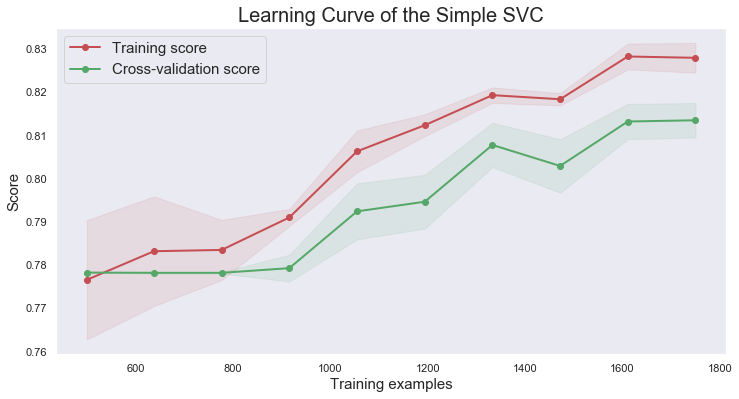

In [28]:
cv_folds = 10
title = "Learning Curve of the Simple SVC"
training_data_sizes = np.linspace(start=500, stop=(1/cv_folds)*len(X_train), num=10, endpoint=True, dtype=np.int64)

plot_learning_curve(simple_svc, title, X_train, y_train, cv=cv_folds, train_sizes=training_data_sizes);

From this learning curve, we can see training score and the cross validation score increase steadily with each other. Looking at this learning curve, it is probably safe to say that the model does not suffer from high bias. Even though our two curves are close to each other, they both have reasonably decent scores (even though as we previously established, 78% was our baseline). Given that we have a large number of features, it's possible we are perhaps overfitting, though the learning curve does not seem to suggest high variance outright. 